# Predicting Remaining Useful Life (RUL) Using SVC and RandomForest

This project aims to predict the Remaining Useful Life (RUL) of aircraft engines using the NASA C-MAPSS dataset. We will utilize Support Vector Classifier (SVC) and RandomForest algorithms to classify engine conditions based on their RUL.

Illustration of a turbofan engine

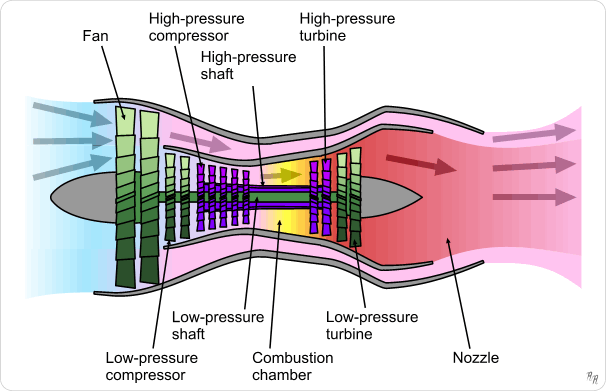

# Importing necessary libraries

In [98]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import learning_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE


# Function to add RUL column

In [99]:
def add_RUL_column(df):
    train_grouped_by_unit = df.groupby(by='unit_number')
    max_time_cycles = train_grouped_by_unit['time_cycles'].max()
    merged = df.merge(max_time_cycles.to_frame(name='max_time_cycle'), left_on='unit_number', right_index=True)
    merged["RUL"] = merged["max_time_cycle"] - merged['time_cycles']
    merged = merged.drop("max_time_cycle", axis=1)
    return merged

#df_train['RUL'] = df_train.groupby('unit_number')['time_cycles'].transform(lambda x: x.max() - x)
#df_valid['RUL'] = df_valid.groupby('unit_number')['time_cycles'].transform(lambda x: x.max() - x)

## Loading Data

In [100]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i + 1) for i in range(0, 21)]
col_names = index_names + setting_names + sensor_names

df_train = pd.read_csv('../input/nasa-cmaps/CMaps/train_FD001.txt', sep='\s+', header=None, index_col=False, names=col_names)
df_valid = pd.read_csv('../input/nasa-cmaps/CMaps/test_FD001.txt', sep='\s+', header=None, index_col=False, names=col_names)
y_valid = pd.read_csv('../input/nasa-cmaps/CMaps/RUL_FD001.txt', sep='\s+', header=None, index_col=False, names=['RUL'])

In [101]:
print(f"DataFrame train shape : {df_train.shape}\nDataFrame valid shape : {df_valid.shape}\nDataFrame y_valid shape : {y_valid.shape}")

DataFrame train shape : (20631, 26)
DataFrame valid shape : (13096, 26)
DataFrame y_valid shape : (100, 1)


In [102]:
print(f'Percentage of the validation dataset: {np.round(df_valid.shape[0] / (df_valid.shape[0] + df_train.shape[0]) * 100, 2)}%')

Percentage of the validation dataset: 38.83%


In [103]:
df_train.head()

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


Three settings of 100 units and time series of 21 sensor measurements are included in the training dataframe FD0001.Every engine functions normally at the start of every time series and breaks down at the conclusion. One operation cycle's worth of data is captured in each row.

**Checking for missing (NaN) values**

In [104]:
df_train.isna().sum()

unit_number    0
time_cycles    0
setting_1      0
setting_2      0
setting_3      0
s_1            0
s_2            0
s_3            0
s_4            0
s_5            0
s_6            0
s_7            0
s_8            0
s_9            0
s_10           0
s_11           0
s_12           0
s_13           0
s_14           0
s_15           0
s_16           0
s_17           0
s_18           0
s_19           0
s_20           0
s_21           0
dtype: int64

Checking target variables info

In [105]:
df_train.loc[:,['unit_number','time_cycles']].describe()

,unit_number,time_cycles
count,20631.000000,20631.000000
mean,51.506568,108.807862
std,29.227633,68.880990
min,1.000000,1.000000
25%,26.000000,52.000000
50%,52.000000,104.000000
75%,77.000000,156.000000
max,100.000000,362.000000


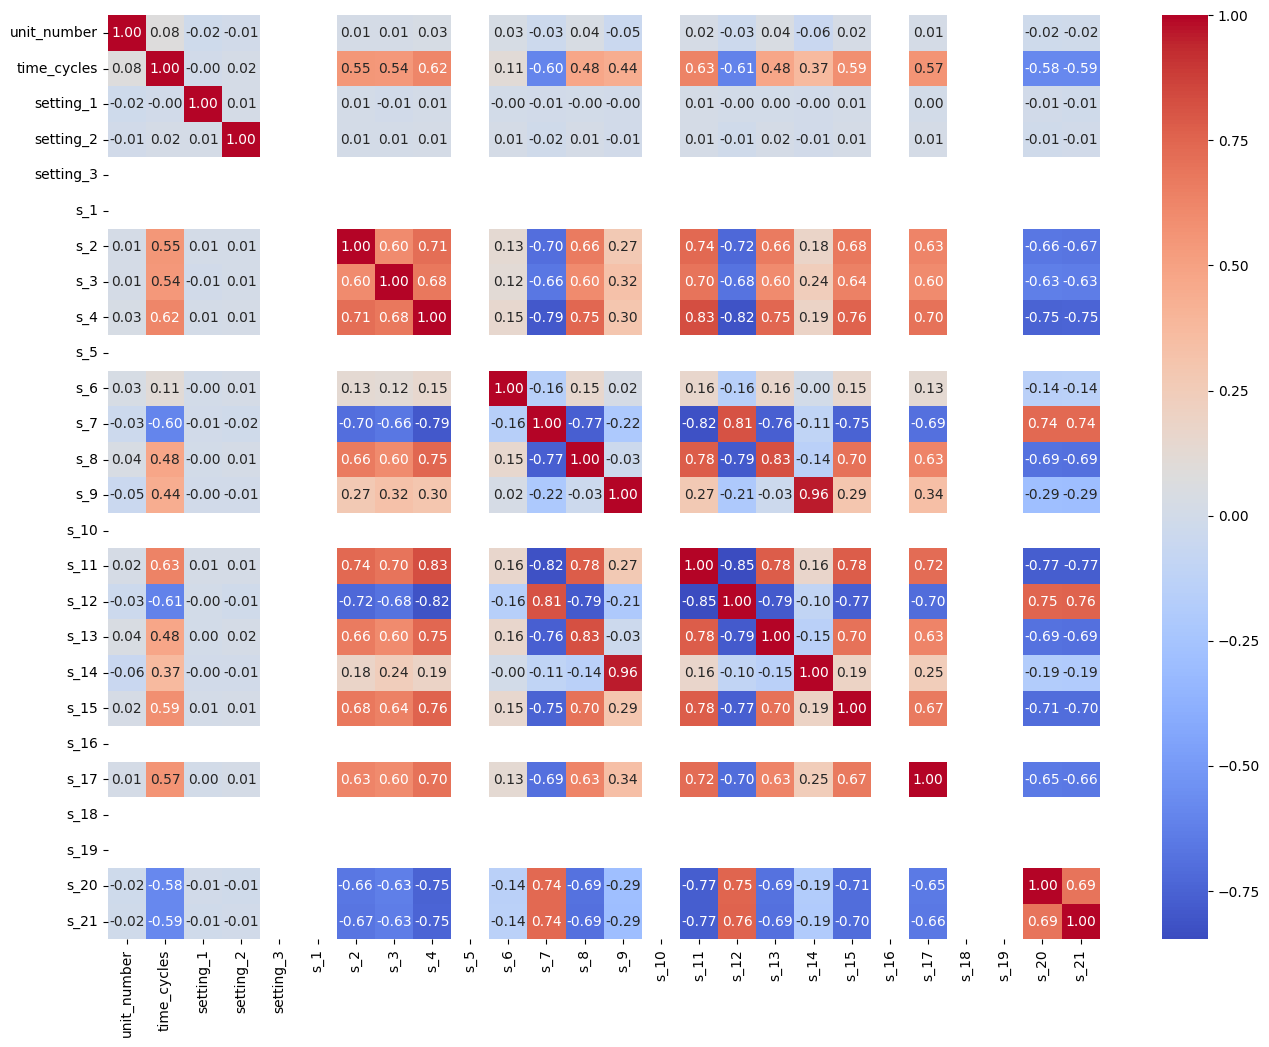

In [106]:
correlation_matrix = df_train.corr()


plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

During initial data exploration and correlation matrix analysis, it was observed that the following features are constants: **setting_3, s_1, s_5, s_10, s_16, s_18, and s_19**. This indicates that these features do not vary across the provided dataset and do not contribute additional information for analysis or modeling purposes.

Such constant features typically carry **little or no information** about data variation and may be considered for removal to streamline data processing and modeling efforts.

In [107]:
# Remove constant features
constant_features = [col for col in df_train.columns if df_train[col].std() == 0]
df_train.drop(columns=constant_features + ['s_5', 's_16'], inplace=True)

**Data visualization**

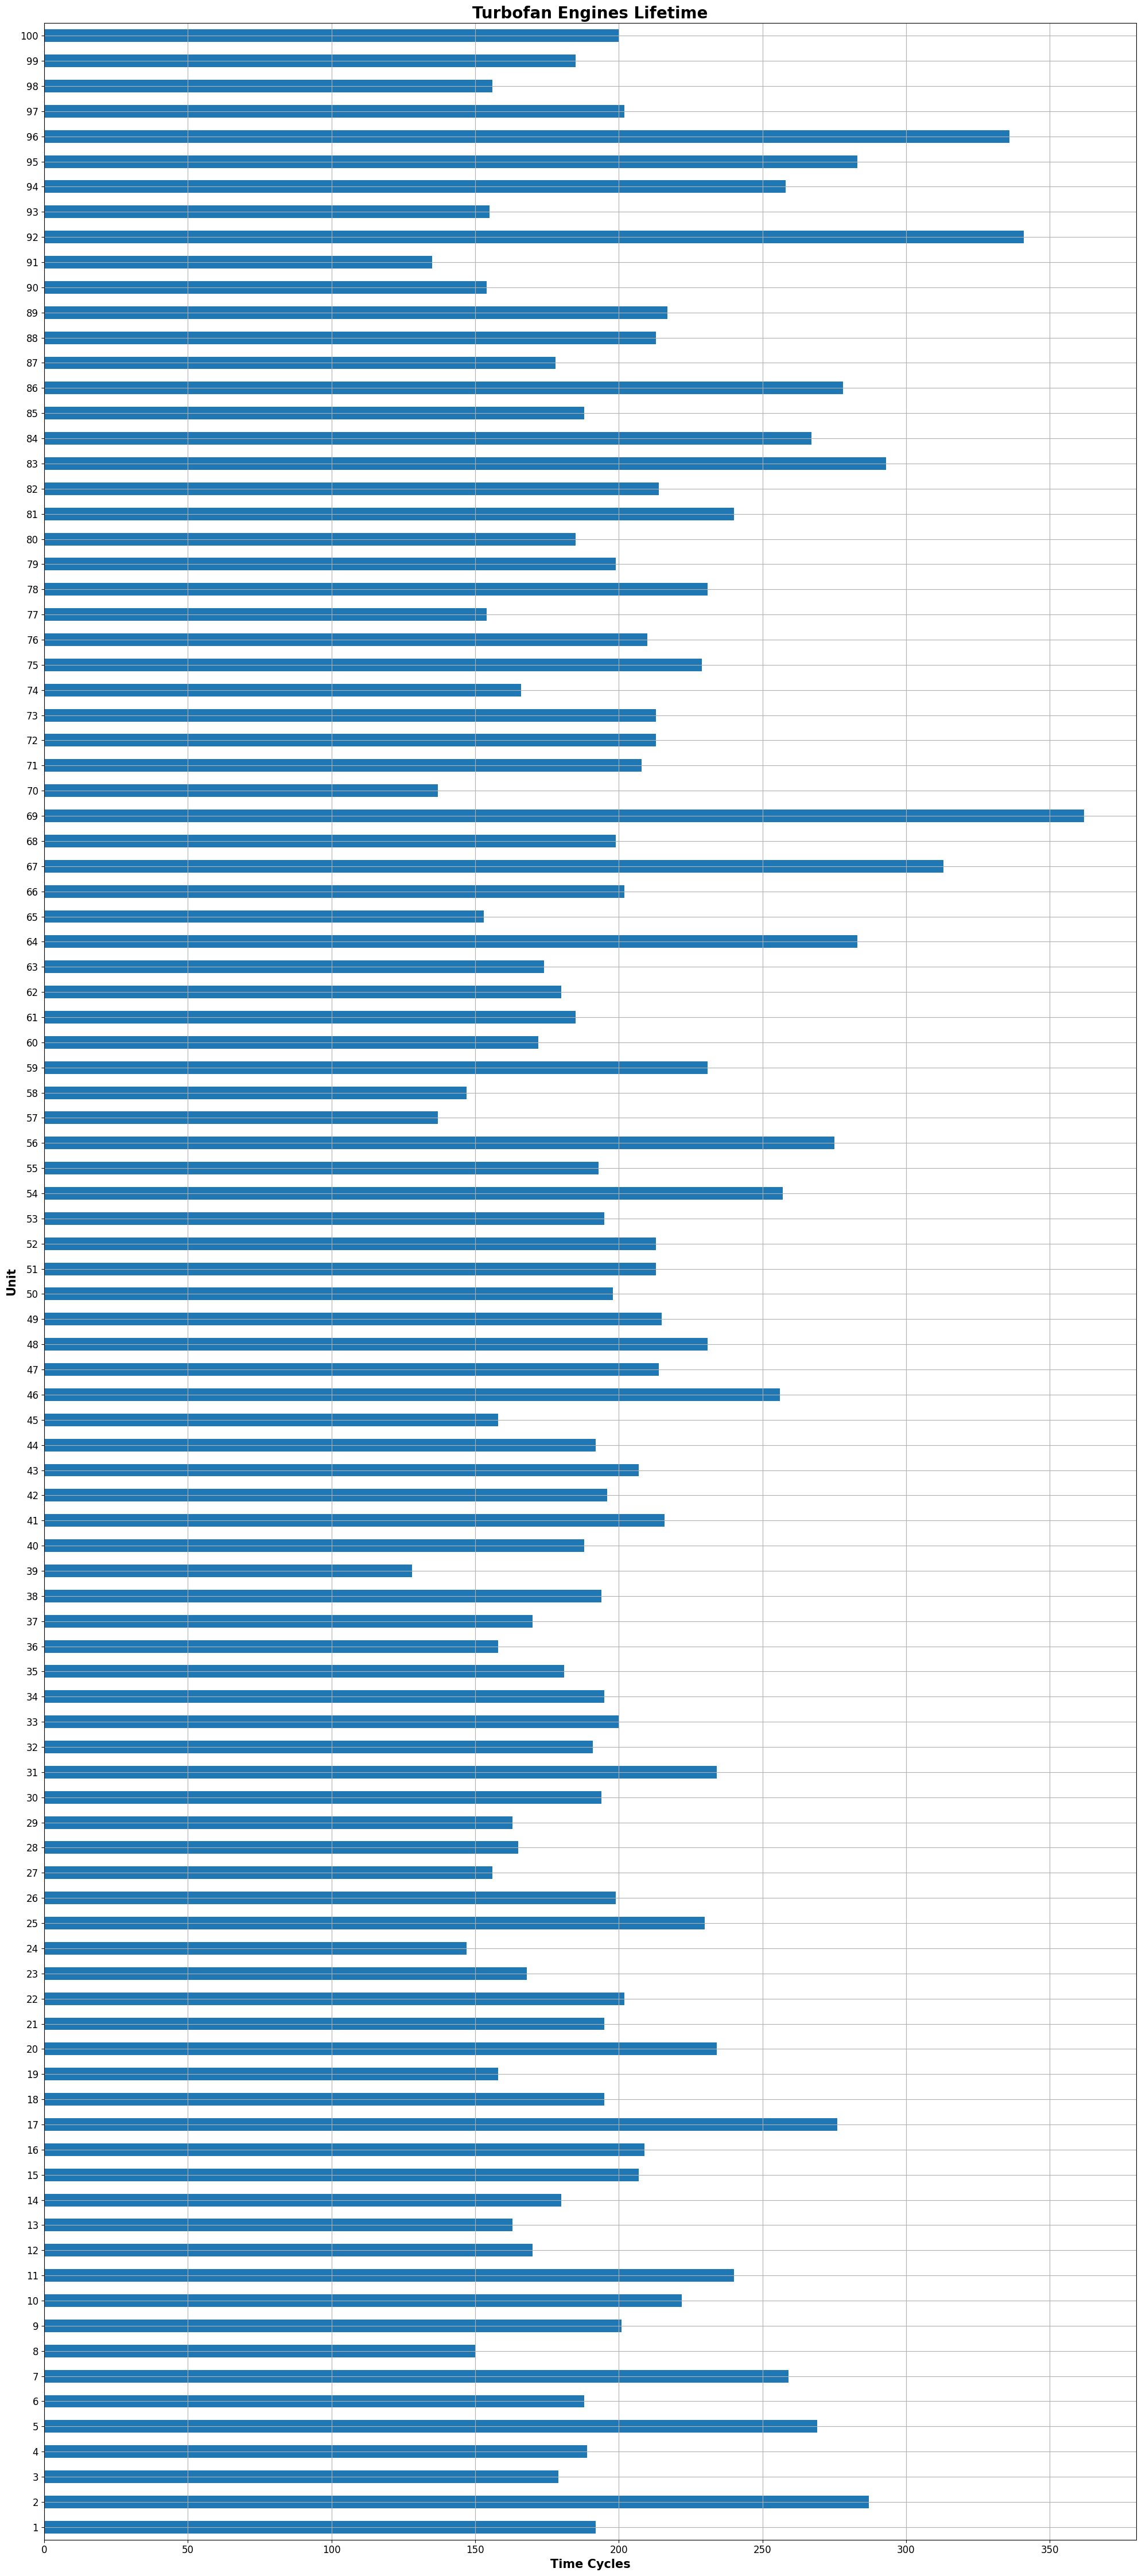

In [108]:
max_time_cycles = df_train[index_names].groupby('unit_number').max()

plt.figure(figsize=(20, 45))
ax = max_time_cycles['time_cycles'].plot(kind='barh', align='center')

plt.title('Turbofan Engines Lifetime', fontweight='bold', size=20)
plt.xlabel('Time Cycles', fontweight='bold', size=15)
plt.ylabel('Unit', fontweight='bold', size=15)
plt.xticks(size=12)
plt.yticks(size=12)
plt.grid(True)
plt.tight_layout()

plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


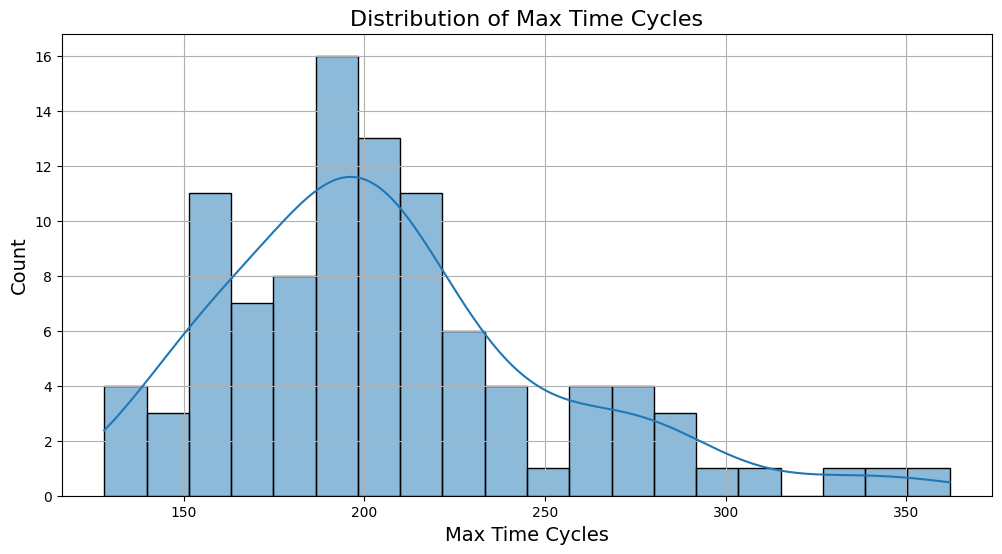

In [109]:
plt.figure(figsize=(12, 6))
sns.histplot(max_time_cycles['time_cycles'], kde=True, bins=20)
plt.xlabel('Max Time Cycles', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Distribution of Max Time Cycles', fontsize=16)
plt.grid(True)
plt.show()

## Adding column 'RUL'


In [110]:
df_train = add_RUL_column(df_train)

## Clustering RUL Values into Two Classes Based on the Distribution of Validation Data


In [111]:
def classify_rul(rul):
    if rul <= 80:
        return 0
    else:
        return 1

df_train['RUL_class'] = df_train['RUL'].apply(classify_rul)

## Checking Class Boundaries

In [112]:
class_ranges = df_train.groupby('RUL_class')['RUL'].agg(['min', 'max'])
print(class_ranges)

           min  max
RUL_class          
0            0   80
1           81  361


Now let's examine how the new variable (RUL) correlates with others. The RUL variable is crucial as it represents the remaining operational cycles before engine failure. Understanding its correlation with other variables can help in identifying predictors of engine degradation and optimizing maintenance strategies.

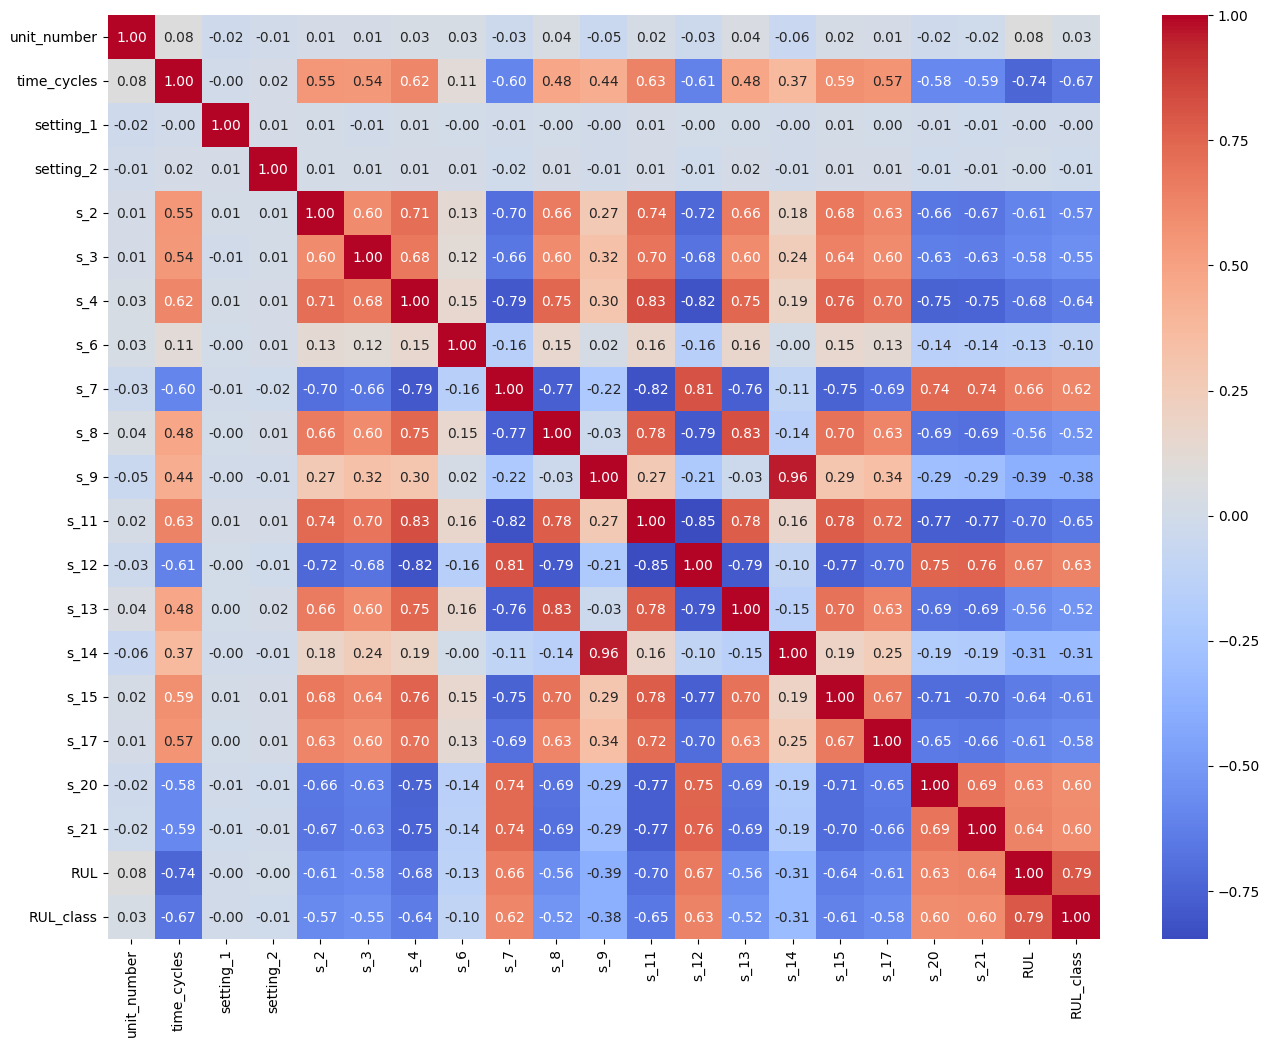

In [113]:
new_correlation_matrix = df_train.corr()


plt.figure(figsize=(16, 12))
sns.heatmap(new_correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

## Removing Unnecessary Columns and Splitting Data into Training and Test Sets

In [114]:
drop_labels = ['unit_number', 'time_cycles', 'RUL', 'RUL_class']
X = df_train.drop(columns=drop_labels + ['RUL_class'])
y = df_train['RUL_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [115]:
df_train['RUL_class'].value_counts()

RUL_class
1    12531
0     8100
Name: count, dtype: int64

In [116]:
y_valid.describe()

,RUL
count,100.00000
mean,75.52000
std,41.76497
min,7.00000
25%,32.75000
50%,86.00000
75%,112.25000
max,145.00000


## Scaling data

In [117]:
scaler = MinMaxScaler() # Using RobustScaler did not improve the results, so the decision was made to use MinMaxScaler.
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Balancing Classes Using SMOTE

In [118]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

## Preparing Validation Data

In [119]:
df_valid_grouped = df_valid.groupby('unit_number').last().reset_index()

df_valid_grouped.drop(columns=constant_features, inplace=True)

X_valid = df_valid_grouped.drop(columns=['unit_number', 'time_cycles', 's_5', 's_16'])
X_valid_scaled = scaler.transform(X_valid)
y_valid_class = y_valid['RUL'].apply(classify_rul).values

## Classification Models with Optimal Parameters

In [120]:
# Classification Models with Optimal Parameters (Chosen Using GridSearchCV)
models = {
    'RandomForest': RandomForestClassifier(
        n_estimators=300,
        max_depth=20,
        min_samples_split=10,
        min_samples_leaf=2,
        random_state=42
    ),
    'SVC': SVC(
        C=1,
        kernel='rbf',
        gamma='scale',
        random_state=42
    )
}


## Function for Training and Evaluating Models

In [121]:
def train_and_evaluate(model_name, model):
    model.fit(X_train_resampled, y_train_resampled)
    
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    y_valid_pred = model.predict(X_valid_scaled)
    
    print(f"{model_name} Train - Accuracy: {accuracy_score(y_train, y_train_pred):.2f}")
    print(f"{model_name} Train - Classification Report:\n{classification_report(y_train, y_train_pred)}")
    
    print(f"{model_name} Test - Accuracy: {accuracy_score(y_test, y_test_pred):.2f}")
    print(f"{model_name} Test - Classification Report:\n{classification_report(y_test, y_test_pred)}")
    
    print(f"{model_name} Valid - Accuracy: {accuracy_score(y_valid_class, y_valid_pred):.2f}")
    print(f"{model_name} Valid - Classification Report:\n{classification_report(y_valid_class, y_valid_pred)}")

## Training and Evaluating Models

In [122]:
for model_name in models:
    train_and_evaluate(model_name, models[model_name])

RandomForest Train - Accuracy: 0.97
RandomForest Train - Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      6075
           1       0.97      0.99      0.98      9398

    accuracy                           0.97     15473
   macro avg       0.97      0.97      0.97     15473
weighted avg       0.97      0.97      0.97     15473

RandomForest Test - Accuracy: 0.88
RandomForest Test - Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      2025
           1       0.88      0.93      0.90      3133

    accuracy                           0.88      5158
   macro avg       0.88      0.87      0.87      5158
weighted avg       0.88      0.88      0.88      5158

RandomForest Valid - Accuracy: 0.88
RandomForest Valid - Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87        45

In [123]:
df_train['RUL_class'].value_counts()

RUL_class
1    12531
0     8100
Name: count, dtype: int64

In [124]:
y_valid.describe()

,RUL
count,100.00000
mean,75.52000
std,41.76497
min,7.00000
25%,32.75000
50%,86.00000
75%,112.25000
max,145.00000


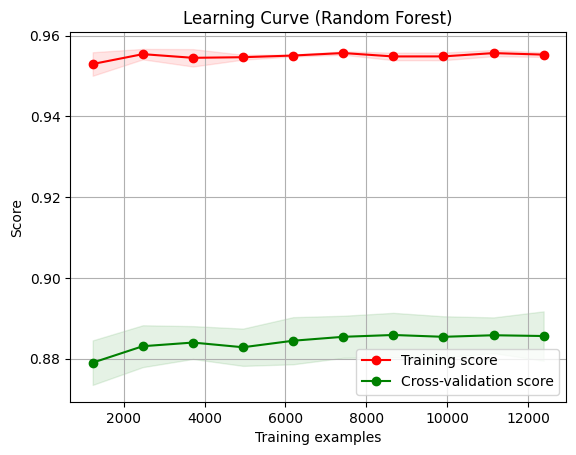

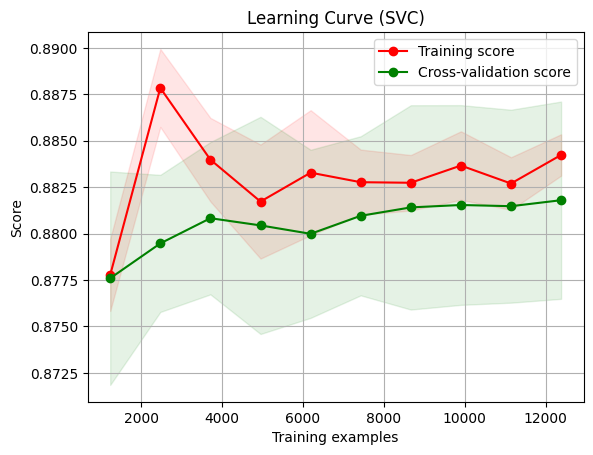

In [127]:
def plot_learning_curve(estimator, title, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# plotting lc for RandomForestClassifier
rf_best = RandomForestClassifier(n_estimators=300, max_depth=20, min_samples_split=10, min_samples_leaf=2, random_state=42)
plot_learning_curve(rf_best, "Learning Curve (Random Forest)", X_train_scaled, y_train)

# plotting lc for SVC
svc_best = SVC(C=1, kernel='rbf', gamma='scale', random_state=42)
plot_learning_curve(svc_best, "Learning Curve (SVC)", X_train_scaled, y_train)

plt.show()

Knowing that trees are somewhat prone to "overfitting" (as seen in the learning curve), the final model was chosen to be SVC, as it demonstrated more stable results on the validation data.